In [1]:
from westat import *

# 导入 UCI_Credit_Card
data = uci_credit_card()

# 将目标变量重命名为“y”
data.rename(columns={'target':'y'},inplace=True)

# 使用 data_split 函数，按随机划分25%的数据到测试集进行数据分区
data_train,data_test = data_split(data,0.25)

## 特征分箱 binning

特征分箱（Binning）作为数据预处理的一部分，也被称为离散分箱或数据分段。分箱把数据根据一定的规则进行分组，使数据变得离散化，以增强模型的稳定性并避免过拟合。
在评分卡建模中，变量分箱（binning）是对连续变量离散化（discretization）的一种称呼。要将logistic模型转换为标准评分卡的形式，这一环节是必须完成的。信用评分卡开发中一般有常用的等距分段、等深分段、最优分段。

- 等距分段（Equval length intervals）：是指分段的区间是一致的，比如年龄以十年作为一个分段；
- 等深分段（Equal frequency intervals）：是先确定分段数量，然后令每个分段中数据数量大致相等；
- 最优分段（Optimal Binning）：又叫监督离散化（supervised discretizaion），使用递归划分（Recursive Partitioning）将连续变量分为分段，背后是一种基于条件推断查找较佳分组的算法（Conditional Inference Tree）。

在实际建模中，分箱一般都是针对连续型数据（如价格、销量、年龄）进行的。但是从理论上，分箱也可以对分类型数据进行。

所以经过分箱后的数据，有以下两个特点：
- 数据可取值的范围变小了
- 数据的可取值会更加确定与稳定
- 数据中信息会变得模糊，不再那么精确


**证据权重 WOE**

全称为 weight of Evidence。WOE表示的是“当前分组中响应客户占所有响应客户的比例”和“当前分组中没有响应的客户占所有没有响应的客户的比例”的差异。也可以理解为当前分组中响应的客户和未响应客户的比值，和所有样本中这个比值的差异。

**WOE 计算公式为：**

$ WOE \;=\;ln\left[\frac{Bad\;Distribution}{Good\;Distribution}\right] $

如果括号内的比值小于1，WOE是负值；反之则是正值。需要注意的是，公式中将违约的分布作为分子只是一种选择，也可以将正常的分布作为分子来定义 WOE。公式中类别顺序的选择隐含着WOE的含义。

在计算WOE之前，需要将变量分段（(bin)

对于一个名义变量的类别i，或连续变量的某个段，WOE可以定义为:

$ WOE_i \;=\;ln\left[\frac{Bad\;Distribution_i}{Good\;Distribution_i}\right] $

需要记住的是,对于类别i，正常和违约的分布分别定义为:

$ Good\,Distribution\,_i\;=\; \frac{Number\,of\,Good_i}{Total \,Number\,of\,Good} $

$ Bad\,Distribution\,_i\;=\; \frac{Number\,of\,Bad_i}{Total \,Number\,of\,Bad} $

$ WOE_i\;=\;ln \left( \frac {\#B_i / \#B_T}{\#G_i / \#G_T} \right) $

 **WOE的特点：**
- 当前分组中，响应的比例越大，WOE值越大；
- 当前分组WOE的正负，由当前分组响应和未响应的比例，与样本整体响应和未响应的比例的大小关系决定，当前分组的比例小于样本整体比例时，WOE为负，当前分组的比例大于整体比例时，WOE为正，当前分组的比例和整体比例相等时，WOE为0。
- WOE的取值范围是全体实数。


**信息价值 IV**

全称为 information value，用于衡量某个变量的信息量。

对于一个名义变量的类别i，或连续变量的某个段，IV可以定义为:：

$ IV_i = \left(\frac{\#B_i}{\#B_T} - \frac{\#G_i}{\#G_T}  \right) * ln \left( \frac{\#B_i/\#B_T}{\#G_i/\#G_T} \right) $

最终变量的IV需要将每个分组的IV值进行加总，公式为：

$ IV = \sum^n_{k=0} IV_i $


IV 解释能力

| IV值 | 解释能力 |
|-------|-------|
| < 0.02 | 无 |
| 0.02 - 0.1 | 低 |
| 0.1 - 0.3 | 中 |
| 0.3 - 0.5 | 高 |
| > 0.5 | 太高，可能有问题 |


**IV 的特点：**
- 对于变量的一个分组，这个分组的响应和未响应的比例与样本整体响应和未响应的比例相差越大，IV值越大，否则，IV值越小；
- 极端情况下，当前分组的响应和未响应的比例和样本整体的响应和未响应的比例相等时，IV值为0；
- IV值的取值范围是[0,+∞)，且当当前分组中只包含响应客户或者未响应客户时，IV = +∞。
- IV无论等于负无穷还是正无穷，都是没有意义的。
IV的缺点，就是不能自动处理变量的分组中出现响应比例为0或100%的情况。遇到响应比例为0或者100%的情况，建议如下：
1. 如果可能，直接把这个分组做成一个规则，作为模型的前置条件或补充条件；
2. 重新对变量进行离散化或分组，使每个分组的响应比例都不为0且不为100%，尤其是当一个分组个体数很小时（比如小于100个），强烈建议这样做，因为本身把一个分组个体数弄得很小就不是太合理。
3. 如果上面两种方法都无法使用，建议人工把该分组的响应数和非响应的数量进行一定的调整。如果响应数原本为0，可以人工调整响应数为1，如果非响应数原本为0，可以人工调整非响应数为1.


**在逻辑回归中筛选变量，一般会考虑下面因素**
- Magnitude of Information Value. Variables with higher Information Values are preferred;
- Linearity. Variables exhibiting a strong linearity are preferred;
- Coverage. Variables with fewer missing values are preferred;
- Distribution. Variables with less uneven distributions are preferred;
- Interpretation. Variables that make more sense in business are preferred.

### 最优分箱 

westat默认使用最优分箱策略进行特征分箱，使用woe_iv函数，可以在分箱的同时进行WoE和IV值的计算，默认数据精度保留4位。
在调用woe_iv函数时，至少需要传入目标数据集和需要进行分箱的特征变量名称

In [22]:
woe_iv(data,col='AGE')

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,AGE,1,"(-inf, 25.5]",3871,1032,2839,12.9033%,15.5515%,12.1512%,26.6598%,0.2467,0.0084
1,AGE,2,"(25.5, 28.5]",4142,852,3290,13.8067%,12.8391%,14.0815%,20.5698%,-0.0924,0.0011
2,AGE,3,"(28.5, 35.5]",8796,1713,7083,29.3200%,25.8137%,30.3159%,19.4748%,-0.1608,0.0072
3,AGE,4,"(35.5, 45.5]",8522,1861,6661,28.4067%,28.0440%,28.5097%,21.8376%,-0.0165,0.0001
4,AGE,5,"(45.5, inf]",4669,1178,3491,15.5633%,17.7517%,14.9418%,25.2302%,0.1723,0.0048
5,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,0.1494,0.0217


### 等频分箱

使用westat进行等频分箱时，需要传入目标数据集和需要进行分箱的特征变量名称，另外也需要指定qcut参数，用来设置需要分箱数

In [3]:
# 等频分箱，计算WoE和IV，默认结果精度保留4位小数，通过 precision = 2 指定结果保留2位小数
woe_iv(data,col='AGE',qcut=5,precision=2)

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,AGE,1,"(20.999, 27.0]",6604,1598,5006,22.01%,24.08%,21.43%,24.20%,0.12,0.00
1,AGE,2,"(27.0, 31.0]",5626,1102,4524,18.75%,16.61%,19.36%,19.59%,-0.15,0.00
2,AGE,3,"(31.0, 37.0]",6728,1380,5348,22.43%,20.80%,22.89%,20.51%,-0.10,0.00
3,AGE,4,"(37.0, 43.0]",5056,1100,3956,16.85%,16.58%,16.93%,21.76%,-0.02,0.00
4,AGE,5,"(43.0, 79.0]",5986,1456,4530,19.95%,21.94%,19.39%,24.32%,0.12,0.00
5,Total,,,30000,6636,23364,100.00%,100.00%,100.00%,22.12%,-0.03,0.01


In [4]:
#使用默认的决策树方法进行分箱
woe_iv(data,col='AGE')

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,AGE,1,"(-inf, 25.5]",3871,1032,2839,12.9033%,15.5515%,12.1512%,26.6598%,0.2467,0.0084
1,AGE,2,"(25.5, 28.5]",4142,852,3290,13.8067%,12.8391%,14.0815%,20.5698%,-0.0924,0.0011
2,AGE,3,"(28.5, 35.5]",8796,1713,7083,29.3200%,25.8137%,30.3159%,19.4748%,-0.1608,0.0072
3,AGE,4,"(35.5, 45.5]",8522,1861,6661,28.4067%,28.0440%,28.5097%,21.8376%,-0.0165,0.0001
4,AGE,5,"(45.5, inf]",4669,1178,3491,15.5633%,17.7517%,14.9418%,25.2302%,0.1723,0.0048
5,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,0.1494,0.0217


In [5]:
#使用默认的决策树方法进行分箱，显示缺失值分组
woe_iv(data,col='AGE',show_missing =True)

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,AGE,1,missing,0,0,0,0.0000%,0.0000%,0.0000%,0.0000%,0.0000,0.0000
1,AGE,2,"(-inf, 25.5]",3871,1032,2839,12.9033%,15.5515%,12.1512%,26.6598%,0.2467,0.0084
2,AGE,3,"(25.5, 28.5]",4142,852,3290,13.8067%,12.8391%,14.0815%,20.5698%,-0.0924,0.0011
3,AGE,4,"(28.5, 35.5]",8796,1713,7083,29.3200%,25.8137%,30.3159%,19.4748%,-0.1608,0.0072
4,AGE,5,"(35.5, 45.5]",8522,1861,6661,28.4067%,28.0440%,28.5097%,21.8376%,-0.0165,0.0001
5,AGE,6,"(45.5, inf]",4669,1178,3491,15.5633%,17.7517%,14.9418%,25.2302%,0.1723,0.0048
6,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,0.1494,0.0217


In [6]:
# 设置输出的分箱小数点位数
woe_iv(data,'AGE',precision=4)

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,AGE,1,"(-inf, 25.5]",3871,1032,2839,12.9033%,15.5515%,12.1512%,26.6598%,0.2467,0.0084
1,AGE,2,"(25.5, 28.5]",4142,852,3290,13.8067%,12.8391%,14.0815%,20.5698%,-0.0924,0.0011
2,AGE,3,"(28.5, 35.5]",8796,1713,7083,29.3200%,25.8137%,30.3159%,19.4748%,-0.1608,0.0072
3,AGE,4,"(35.5, 45.5]",8522,1861,6661,28.4067%,28.0440%,28.5097%,21.8376%,-0.0165,0.0001
4,AGE,5,"(45.5, inf]",4669,1178,3491,15.5633%,17.7517%,14.9418%,25.2302%,0.1723,0.0048
5,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,0.1494,0.0217


In [7]:
# 按照指定的切分点 分箱，并计算 WoE 和 IV
woe_iv(data,'AGE',bins=[-inf,20,30,40,50,inf])

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,AGE,1,"(-inf, 20.0]",0,0,0,0.0000%,0.0000%,0.0000%,0.0000%,0.0000,0.0000
1,AGE,2,"(20.0, 30.0]",11013,2471,8542,36.7100%,37.2363%,36.5605%,22.4371%,0.0183,0.0001
2,AGE,3,"(30.0, 40.0]",10713,2189,8524,35.7100%,32.9867%,36.4835%,20.4331%,-0.1008,0.0035
3,AGE,4,"(40.0, 50.0]",6005,1399,4606,20.0167%,21.0820%,19.7141%,23.2973%,0.0671,0.0009
4,AGE,5,"(50.0, inf]",2269,577,1692,7.5633%,8.6950%,7.2419%,25.4297%,0.1829,0.0027
5,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,0.1675,0.0072


In [8]:
# 使用已经分箱后的数据计算woe和iv
age_bins = [-inf, 25, 40, 50, 60, 70, inf]
data['bin_age'] = pd.cut(data['AGE'],bins=age_bins).astype(str)

woe_iv(data,'bin_age',method='discrete')

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,bin_age,1,"(-inf, 25.0]",3871,1032,2839,12.9033%,15.5515%,12.1512%,26.6598%,0.2467,0.0084
1,bin_age,2,"(25.0, 40.0]",17855,3628,14227,59.5167%,54.6715%,60.8928%,20.3192%,-0.1078,0.0067
2,bin_age,3,"(40.0, 50.0]",6005,1399,4606,20.0167%,21.0820%,19.7141%,23.2973%,0.0671,0.0009
3,bin_age,4,"(50.0, 60.0]",1997,504,1493,6.6567%,7.5949%,6.3902%,25.2379%,0.1727,0.0021
4,bin_age,5,"(60.0, 70.0]",257,68,189,0.8567%,1.0247%,0.8089%,26.4591%,0.2364,0.0005
5,bin_age,6,"(70.0, inf]",15,5,10,0.0500%,0.0753%,0.0428%,33.3333%,0.5655,0.0002
6,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,1.1808,0.0188


In [9]:
data.drop(columns=['bin_age'],inplace=True)

In [10]:
# 使用决策树方法计算计算 WoE 和 IV
woe_iv(data,'PAY_0',method='tree')

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,PAY_0,1,"(-inf, -2.0]",2759,365,2394,9.1967%,5.5003%,10.2465%,13.2294%,-0.6221,0.0295
1,PAY_0,2,"(-2.0, -1.0]",5686,954,4732,18.9533%,14.3761%,20.2534%,16.7781%,-0.3428,0.0201
2,PAY_0,3,"(-1.0, 0.0]",14737,1888,12849,49.1233%,28.4509%,54.9949%,12.8113%,-0.6591,0.1749
3,PAY_0,4,"(0.0, 1.0]",3688,1252,2436,12.2933%,18.8668%,10.4263%,33.9479%,0.5931,0.0501
4,PAY_0,5,"(1.0, inf]",3130,2177,953,10.4333%,32.8059%,4.0789%,69.5527%,2.0848,0.5989
5,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,1.0539,0.8736


In [11]:
# 指定缺失值类型，并使用默认的决策树分箱方法进行分箱，计算WoE和IV, 
data['PAY_0'][0] = np.nan
data['PAY_0'][1] = -99999

woe_iv(data,col='PAY_0',missing = [-99999])

C:\Users\about\AppData\Local\Temp\ipykernel_16688\1355770748.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PAY_0'][0] = np.nan


,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,PAY_0,1,missing,2,2,0,0.0067%,0.0301%,0.0000%,100.0000%,0.0000,0.0000
1,PAY_0,2,"(-inf, -0.5]",8444,1318,7126,28.1467%,19.8614%,30.4999%,15.6087%,-0.4289,0.0456
2,PAY_0,3,"(-0.5, 0.5]",14737,1888,12849,49.1233%,28.4509%,54.9949%,12.8113%,-0.6591,0.1749
3,PAY_0,4,"(0.5, 1.5]",3688,1252,2436,12.2933%,18.8668%,10.4263%,33.9479%,0.5931,0.0501
4,PAY_0,5,"(1.5, inf]",3129,2176,953,10.4300%,32.7908%,4.0789%,69.5430%,2.0843,0.5984
5,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,1.5894,0.8691


## 查看WoE 和 IV

In [12]:
# 按照默认的决策树方法，计算WoE 和 IV，并查看WoE的分布
view_woe_iv(data,'AGE')

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV,WoE.
0,AGE,1,"(-inf, 25.5]",3871,1032,2839,12.9033%,15.5515%,12.1512%,26.6598%,0.2467,0.0084,0.246700
1,AGE,2,"(25.5, 28.5]",4142,852,3290,13.8067%,12.8391%,14.0815%,20.5698%,-0.0924,0.0011,-0.092400
2,AGE,3,"(28.5, 35.5]",8796,1713,7083,29.3200%,25.8137%,30.3159%,19.4748%,-0.1608,0.0072,-0.160800
3,AGE,4,"(35.5, 45.5]",8522,1861,6661,28.4067%,28.0440%,28.5097%,21.8376%,-0.0165,0.0001,-0.016500
4,AGE,5,"(45.5, inf]",4669,1178,3491,15.5633%,17.7517%,14.9418%,25.2302%,0.1723,0.0048,0.172300
5,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,0.1494,0.0217,0.149400


In [13]:
# 按照默认的决策树方法，计算WoE 和 IV，并查看WoE的分布 , 设置显示的颜色为绿色
view_woe_iv(data,'AGE',color='green')

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV,WoE.
0,AGE,1,"(-inf, 25.5]",3871,1032,2839,12.9033%,15.5515%,12.1512%,26.6598%,0.2467,0.0084,0.246700
1,AGE,2,"(25.5, 28.5]",4142,852,3290,13.8067%,12.8391%,14.0815%,20.5698%,-0.0924,0.0011,-0.092400
2,AGE,3,"(28.5, 35.5]",8796,1713,7083,29.3200%,25.8137%,30.3159%,19.4748%,-0.1608,0.0072,-0.160800
3,AGE,4,"(35.5, 45.5]",8522,1861,6661,28.4067%,28.0440%,28.5097%,21.8376%,-0.0165,0.0001,-0.016500
4,AGE,5,"(45.5, inf]",4669,1178,3491,15.5633%,17.7517%,14.9418%,25.2302%,0.1723,0.0048,0.172300
5,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,0.1494,0.0217,0.149400


In [14]:
# 按照默认的决策树方法，计算WoE 和 IV，并查看WoE的分布，设置显示的颜色
view_woe_iv(data,'AGE',color='#02B057')

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV,WoE.
0,AGE,1,"(-inf, 25.5]",3871,1032,2839,12.9033%,15.5515%,12.1512%,26.6598%,0.2467,0.0084,0.246700
1,AGE,2,"(25.5, 28.5]",4142,852,3290,13.8067%,12.8391%,14.0815%,20.5698%,-0.0924,0.0011,-0.092400
2,AGE,3,"(28.5, 35.5]",8796,1713,7083,29.3200%,25.8137%,30.3159%,19.4748%,-0.1608,0.0072,-0.160800
3,AGE,4,"(35.5, 45.5]",8522,1861,6661,28.4067%,28.0440%,28.5097%,21.8376%,-0.0165,0.0001,-0.016500
4,AGE,5,"(45.5, inf]",4669,1178,3491,15.5633%,17.7517%,14.9418%,25.2302%,0.1723,0.0048,0.172300
5,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,0.1494,0.0217,0.149400


In [15]:
# 按照等频分箱，将特征分为5箱，计算WoE 和 IV，并查看WoE的分布
view_woe_iv(data,'AGE',qcut=5,precision=2)

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV,WoE.
0,AGE,1,"(20.999, 27.0]",6604,1598,5006,22.01%,24.08%,21.43%,24.20%,0.12,0.00,0.120000
1,AGE,2,"(27.0, 31.0]",5626,1102,4524,18.75%,16.61%,19.36%,19.59%,-0.15,0.00,-0.150000
2,AGE,3,"(31.0, 37.0]",6728,1380,5348,22.43%,20.80%,22.89%,20.51%,-0.10,0.00,-0.100000
3,AGE,4,"(37.0, 43.0]",5056,1100,3956,16.85%,16.58%,16.93%,21.76%,-0.02,0.00,-0.020000
4,AGE,5,"(43.0, 79.0]",5986,1456,4530,19.95%,21.94%,19.39%,24.32%,0.12,0.00,0.120000
5,Total,,,30000,6636,23364,100.00%,100.00%,100.00%,22.12%,-0.03,0.01,-0.030000


## 计算WoE 并绘图

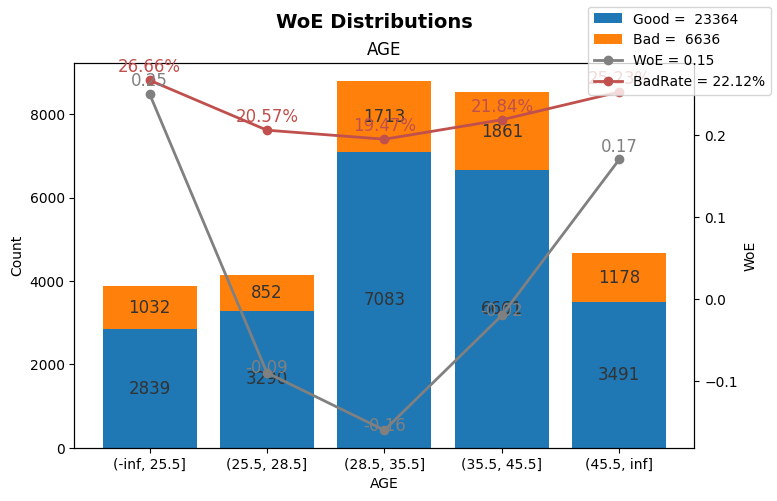

In [16]:
# 根据默认参数，将特征分箱，计算WoE,并展示图形
plot_woe(data,'AGE')

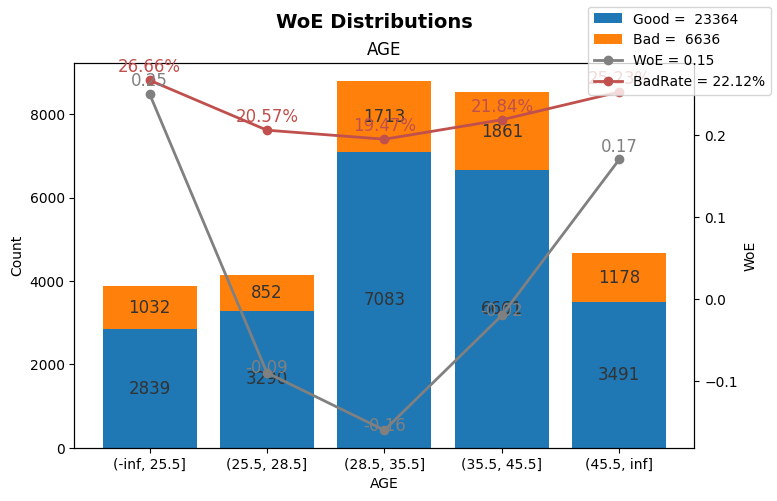

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,AGE,1,"(-inf, 25.5]",3871,1032,2839,12.90%,15.55%,12.15%,26.66%,0.25,0.01
1,AGE,2,"(25.5, 28.5]",4142,852,3290,13.81%,12.84%,14.08%,20.57%,-0.09,0.00
2,AGE,3,"(28.5, 35.5]",8796,1713,7083,29.32%,25.81%,30.32%,19.47%,-0.16,0.01
3,AGE,4,"(35.5, 45.5]",8522,1861,6661,28.41%,28.04%,28.51%,21.84%,-0.02,0.00
4,AGE,5,"(45.5, inf]",4669,1178,3491,15.56%,17.75%,14.94%,25.23%,0.17,0.00
5,Total,,,30000,6636,23364,100.00%,100.00%,100.00%,22.12%,0.15,0.02


In [17]:
# 根据默认参数，将特征分箱，并计算WoE,并展示图形 和 数据
plot_woe(data,'AGE',return_data =True)

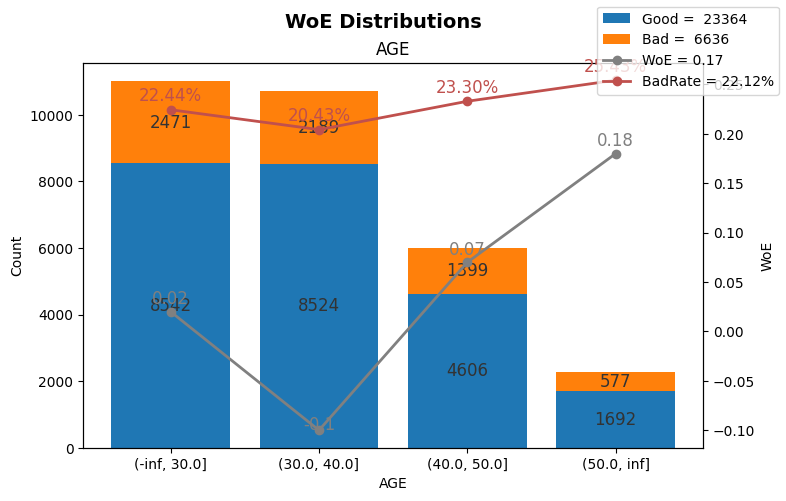

In [18]:
# 根据指定切分点计算WoE,并展示图形
plot_woe(data,'AGE',bins=[-inf,30,40,50,inf])

In [19]:
woe_iv(data,'AGE',bins=[-inf,30,40,50,inf])

,Name,No.,Bin,#Total,#Bad,#Good,%Total,%Bad,%Good,%BadRate,WoE,IV
0,AGE,1,"(-inf, 30.0]",11013,2471,8542,36.7100%,37.2363%,36.5605%,22.4371%,0.0183,0.0001
1,AGE,2,"(30.0, 40.0]",10713,2189,8524,35.7100%,32.9867%,36.4835%,20.4331%,-0.1008,0.0035
2,AGE,3,"(40.0, 50.0]",6005,1399,4606,20.0167%,21.0820%,19.7141%,23.2973%,0.0671,0.0009
3,AGE,4,"(50.0, inf]",2269,577,1692,7.5633%,8.6950%,7.2419%,25.4297%,0.1829,0.0027
4,Total,,,30000,6636,23364,100.0000%,100.0000%,100.0000%,22.1200%,0.1675,0.0072


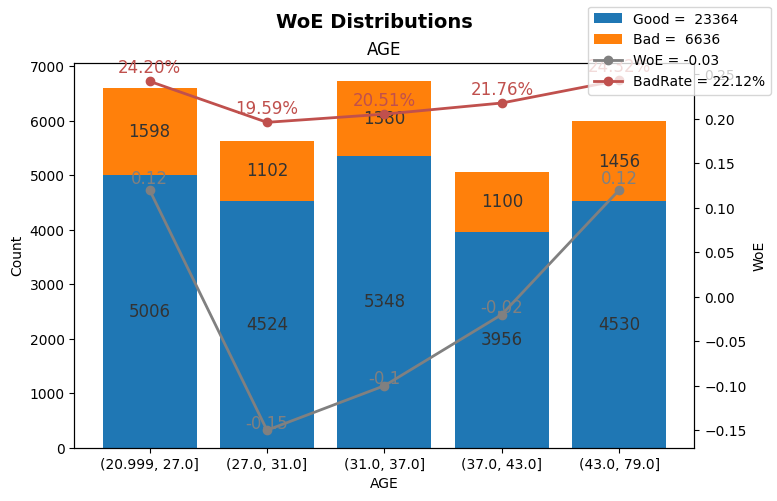

In [20]:
# 根据等频分箱，将特征分为5箱，并计算WoE,并展示图形
plot_woe(data,'AGE',qcut=5)

IndexError: list index out of range

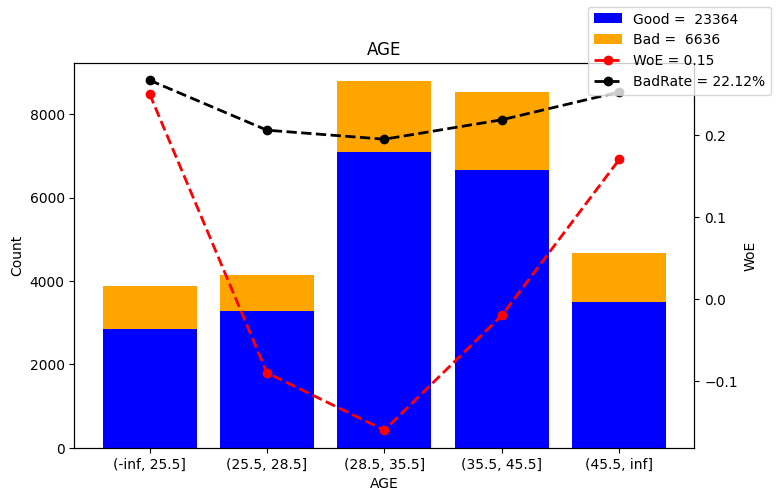

In [21]:
# 根据默认的决策树方法分箱，并计算WoE,设置图形的颜色和样式，并展示图形
plot_woe(data,'AGE',color=['blue','orange','red','black'],linewidth=2,linestyle='--')

## 计算 IV 并绘图

In [ ]:
# 根据默认的决策树方法分箱，并计算IV，展示图形
plot_iv(data,'PAY_0')

In [ ]:
# 根据默认的决策树方法分箱，并计算IV，展示图形 和 数据
plot_iv(data,'PAY_0',return_data=True)

In [ ]:
# 根据决策树方法分箱，并计算IV，展示图形
plot_iv(data,'PAY_0',method='tree')

In [ ]:
# 根据等频分箱，将特征分为5箱，并计算IV,展示图形
plot_iv(data,'PAY_0',qcut=5)

In [ ]:
# 根据指定的切分点，将特征分箱，并计算IV,展示图形
plot_iv(data,'PAY_0',bins=[-inf,1,inf])

### 获取列的数据类型，离散型、连续型

In [ ]:
col_types = get_data_type(data)
col_types

## 决策树分箱

In [ ]:
# 根据决策树方法，获取特征的分箱切分点结果
tree_bins(data, 'AGE', max_leaf_nodes=4,min_samples_leaf=0.05)

## 批量决策树分箱

In [ ]:
data_bins = get_data_bins(data,max_leaf_nodes=4)
data_bins

## 手动调整分箱

In [ ]:
data_bins_adjust = update_bins(data_bins,
[
['AGE',[-inf,20,30,40,50,inf]],
['BILL_AMT1',[-inf,1000,8000,50000,inf]],
])
data_bins_adjust

## 数据离散化

In [ ]:
# 根据决策树分箱，并将数据离散化
data_discrete(data)

In [ ]:
# 按照调整后的分箱结果进行离散化
data_train_discrete = data_discrete(data_train,col_bin = data_bins_adjust)
data_train_discrete.head()

## WoE 转换

In [ ]:
# 使用已经离散化的数据，批量进行WoE转换
data_train_woe = woe_transform(data_train_discrete)
data_train_woe.head()

In [ ]:
## 指定 criterion='discrete'，使用已经离散化的列计算WoE和IV
woe_iv(data_train_discrete, 'AGE',method='discrete')

## 批量计算全部特征的IV

In [ ]:
# 使用默认的决策树分箱方法，批量计算数据集所有变量的IV
df_iv = data_iv(data_train)  
df_iv

## 根据离散化的数据，批量计算IV

In [ ]:
# 根据离散化的数据，批量计算IV
df_iv = data_iv(data_train_discrete,method='discrete',precision=4)  
df_iv

## 通过最小IV >= 0.02 和最大相关性 <=0.6 筛选特征

In [ ]:
# 通过最小IV >= 0.02 和最大相关性 <=0.6 筛选特征
# 只返回筛选后保留的特征
iv_corr(data_train,df_iv,min_iv = 0.02,max_corr = 0.6)

## 通过最小IV >= 0.1 筛选特征

In [ ]:
iv_corr(data_train,df_iv,min_iv = 0.1,max_corr=1)

## 通过最小IV >= 0.02 和最大相关性 <=0.6 筛选特征，并返回删除的特征

In [ ]:
# 返回筛选后保留的特征、根据IV删除的特征、根据corr删除的特征、相关矩阵
col_keep,col_drop_by_iv,col_drop_by_corr,iv_corr_result = iv_corr(data_train,df_iv,min_iv = 0.02,max_corr=0.5,return_drop=True)
col_keep

In [ ]:
#根据IV删除的特征
col_drop_by_iv

In [ ]:
#根据corr删除的特征
col_drop_by_corr

In [ ]:
# IV 和相关性矩阵
iv_corr_result.head()

## 逐步回归筛选特征

In [ ]:
#逐步回归选择特征
col_result = stepwise_lr(data_train)
col_result

In [ ]:
#逐步回归选择特征，并显示逐步回归详情
col_result = stepwise_lr(data_train,verbose=True)
col_result

In [ ]:
import statsmodels.api as sm

y = data_train_woe['y']
x = data_train_woe[col_result]
x = sm.add_constant(x)

lr = sm.Logit(y, x).fit(disp=0)
lr.summary()

## 查看特征相关性图

In [ ]:
plot_corr(data_train[col_keep])

In [ ]:
# 批量计算WoE，使用默认的决策树分箱方法
data_iv(data,precision=4)  

In [ ]:
# 批量计算IV，等频分箱，分为5箱
data_iv(data,qcut=5)  

In [ ]:
# 根据分箱后的数据，批量计算iv
data_iv(data_train_discrete)

## 评分卡开发

In [ ]:
# 按照默认参数，开发评分卡
# 默认基础分为600，PDO=50

# 输入训练集数据 和 调整后分箱，开发评分卡
scorecard = get_scorecard(data_train[col_keep + ['y']] ,data_bins_adjust)
scorecard

In [ ]:
# 设置数据精度，并返回逻辑回归模型的详细内容
scorecard,lr,a,b = get_scorecard(data_train[col_keep + ['y']] ,data_bins_adjust,precision=4,return_lr=True)

# 导出评分卡为 excel
scorecard.to_excel('scorecard.xlsx')

In [ ]:
# 查看逻辑回归模型的详细内容
lr.summary()

## 获取模型变量的IV表单

In [ ]:
#获取模型变量的IV表单
model_iv(data_train_discrete[col_keep+['y']])  